# Projet_CD2
Projet de Maths du cours Calcul Différentiel II

In [1]:
#Importations des bibliothèques nécéssaires
from mpl_toolkits.mplot3d import Axes3D
#import autograd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## I) Amorce
Question : À quelle condition raisonnable portant sur $f(0, 0), f(0, 1)$ et le réel
$c$ est-on certain qu’il existe un $t \in [0, 1]$ tel que $f(0, t) = c$ ? Développer une
fonction qui renvoie un flottant éloigné d’au plus `eps` d’un tel `t` ou `None` si la condition
évoquée ci-dessus n’est pas satisfaite.

Il suffit que la fonction $t \longrightarrow f(0,t)$ soit continue sur $[0,1]$ (ce qui est le cas car $f$ est continûment différentiable), et que $(f(0,0)-c)(f(0,1)-c) \leq 0$ (i.e $c \in [f(0,0), f(0,1)]$ ou $c \in [f(0,1), f(0,0)]$ ) pour appliquer le TVI.

Voir la fonction `find_seed(g, c=0, eps=2**(-26))`.



In [2]:
def find_seed(g, c=0, eps=2**(-26)):
    """Methode renvoyant un réel t de [0,1] tel que g(t) = c.
    La fonction lève une valueError si jamais (g(0)-c)(g(1)-c) > 0"""
    if (g(0)-c)*(g(1)-c) > 0:
        raise ValueError("Erreur : aucune garantie qu'un t tel que g(t) = c existe !")
    # On privilégie la dichotomie à la méthode de Newton car il faut travailler avec le eps
    return dicho(lambda t : g(t) - c,0,1,eps)

def dicho(g,a,b,eps):
    """Méthode récursive utilisant le principe de la dichotomie pour exploiter le TVI"""
    m = (a+b)/2
    if b-a <= 2*eps:
        return m
    elif g(a)*g(m) <= 0:
        return dicho(g,a,m,eps)
    else:
        return dicho(g,m,b,eps)


# Test avec la fonction sin et c=1/2 pour retourner la valeur de pi/6
print("$\pi$ /6 = " + str(find_seed(np.sin, c=1/2)))

$\pi$ /6 = 0.523598775267601


## II) Propagation
On souhaite implémenter une fonction dont la signature est :

`def simple_contour(f, c=0.0, delta=0.01):
...
return (x, y)`


qui renvoie un fragment de ligne de niveau de valeur c de f, sous la forme
de deux tableaux (1 dimension) d’abscisses et d’ordonnées de points de cette ligne. Les
points devront être espacés d’approximativement delta. En cas d’impossibilité
de générer un tel fragment, deux tableaux vides devront être renvoyés.

### 1) Outils mathématiques à disposition
On commence par mettre en place les différents outils mathématiques dont nous allons avoir besoin pour définir `simple_contour`.

On va dans un premier temps utiliser la méthode du plan tangent à l'aide du gradient (préférable à la méthode de Newton car beaucoup plus rapide en temps).

In [3]:
def grad(f): # On va ensuite l'utiliser pour déterminer le plan tangent
    """Retourne la fonction grad(f)"""
    h = 10**(-10)
    return lambda x,y : np.array((f(x+h,y)-f(x,y), f(x,y+h)-f(x,y)))/h

def derive(g):
    """Retourne la dérivée de g par dérivation numérique (g'(x) ≈ (g(x+h)-g(x))/h à l'ordre 1),
    donc si g est à une seule variable"""
    h = 10**(-10)
    return lambda t : (g(t+h)-g(t))/h

def creerPlanTg(f, x0, y0):
    """Retourne une fonction donnant le plan tangent en f(x0, y0)"""
    gradFEnM0 = grad(f)(x0,y0)
    return lambda x,y : gradFEnM0[0]*(x-x0) + gradFEnM0[1]*(y-y0) + f(x0,y0)

### 2) Premiers essais
Quelques test pour essayer de plot en 3D

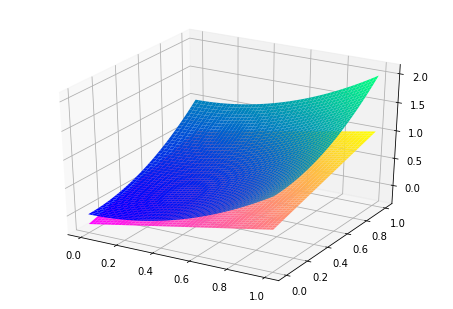

In [4]:
def f(x, y):
    """Fonction f avec laquelle on travaille"""
    return np.power(x,2) + np.power(y,2) # f(x, y) = x^2 + y^2
    # return np.exp(-10*(np.power(x-0.5,2)+np.power(y-0.5,2)))


# Création du graphe en 3D de f
domain_x = np.linspace(0, 1)   
domain_y = np.linspace(0, 1)
X, Y = np.meshgrid(domain_x, domain_y)
fig = plt.figure()
ax = Axes3D(fig)

# On trace f en bleu/vert
ax.plot_surface(X, Y, f(X, Y), cmap='winter')

# Test de tracé du plan tg en un point (x0,y0) en rouge/jaune
x0, y0 = 0.3, 0.3
ax.scatter(x0,y0, f(x0,y0), s=10)
planEnM = creerPlanTg(f, x0, y0)
ax.plot_surface(X, Y, planEnM(X,Y), cmap='spring')

### 3) Première approche
Le but est de trouver la ligne de niveau de notre fonction $f$ caractérisée par son altitude c.
On va pour résoudre ce problème :
- commencer en partant d'un point $(x_0,0, z_0)$ trouvé sur l'arrête gauche en utilisant le TVI comme précédemment, où $z_0 = c$. On note ce point $M_0 = (x_0,y_0, z_0)$ avec donc $y_0 = 0$
- On va alors, pour créer le point $M_1 = (x_1,y_1, z_1)$, regarder la droite formée par l'intersection du plan tangent à $f$ en $M_0$ et le plan d'équation $z=c$. On trouve alors exactement deux points se situant à une distance $\delta$ de $M_0$, mais à moins d'être dans le cas particulier (donc impossible en pratique) ou la droite est parallèle à l'axe des abscisses, un seul de ces deux points possède une coordonnée $x$ positive (plus généralement, un seul de ces deux points est dans le domaine). On note alors ce point $M_1$.
- On réutilise la même méthode pour construire ainsi par récurence la suite de points $(M_n)$ qui donne une bonne approximation de la courbe de niveau (approximation d'autant meilleur que $\delta$ est petit). Il n'y a jamais de problème de choix entre les deux points possibles sur la droite car l'un d'entre eux est $M_{n-1}$, donc il suffit de prendre l'autre.

De manière graphique, on se place directement dans le plan $z=c$, et l'on trace en bleu la ligne de niveau que l'on souhaite justement approchée.

In [5]:
%%html 
<center><img src = "Explications/Figure_1.png", width = 500)>

On trouve en se baladant sur l'arrête gauche le point $M_0$

In [6]:
%%html
<center><img src = "Explications/Figure_2.png", width = 500)>

On trace alors la droite D, qui est donc la tangante à notre ligne de niveau dans le plan $z=c$

In [7]:
%%html
<center><img src = "Explications/Figure_3.png", width = 500)>

On garde le seul point de cette droite à une distance $\delta$ de $M_0$ que l'on nomme $M_1$.

In [8]:
%%html
<center><img src = "Explications/Figure_4.png", width = 500)>

Mathématiquement, la droite $D$ décrite ci dessus possède les caractéristiques suivantes :
$$\forall (x,y,z) \in D, \left\{
    \begin{array}{ll}
        \frac{\partial f}{\partial x}(M_0) \times (x-x_0) + \frac{\partial f}{\partial y}(M_0) \times (y-y_0) = 0 \textit{ (appartient au plan tangent à $f$ en $M_0$)}\\
        z - z_0 = 0 \textit{ (appartient au plan d'équation $z = c$ par définition d'une courbe de niveau)}
    \end{array}
\right.$$

Donc si l'on cherche les points éloignés de $\delta$ de $M_0$, ce qui se traduit par $(x-x_0)^2 + (y-y_0)^2 = \delta ^2$, on se retrouve à résoudre un système de la forme :
$$\lambda a + \mu b = 0 \text{ et } a^2 + b^2 = \delta ^2$$
Sous réserve que $\lambda$ et $\mu$ soient non nuls (toujours le cas en pratique, comme ce sont les coordonnées du gradient de $f$ en $M_0$), ce système se résout et l'on trouve alors deux couples de solutions qui sont les suivants :

$$\left\{
    \begin{array}{ll}
        a =  \eta \mu \\
        b =  \eta \lambda
    \end{array}
\right.
\text{ ou }
\left\{
    \begin{array}{ll}
        a =  \eta \mu \\
        b =  \eta \lambda
    \end{array}
\right. 
\text{ avec } \eta = \frac{\delta}{\sqrt{\lambda^2 + \mu^2}}$$


On garde, pour le cas où l'on cherche $M_1$, la solution qui se trouve dans le domaine $[0,1]^2$, et pour les cas où l'on cherche $M_{n+1}$, celle qui n'est pas $M_{n-1}$ (ce qui en pratique se fait en regardant le point le plus éloigné de $M_{n-1}$ entre les deux points candidats).

### 4) Implémentation

On commence donc par définir les fonctions de `RechercheM0ArreteX` qui seront là pour trouver le point de départ sur lequel travaillé, d'abord celle de l'énoncé en partant de l'arrête gauche en utilisant donc une méthode de type dichotomie, mais aussi les autres sur le même principe.

In [9]:
# Fonction de recherche sur chaque arrête du carré défini sur [0;1]x[0;1]
def RechercheM0ArreteGauche(f, c):
    return (0, find_seed(lambda t : f(0,t), c))

def RechercheM0ArreteDroite(f, c):
    return (1, find_seed(lambda t : f(1,t), c))


def RechercheM0ArreteHaute(f, c):
    return (find_seed(lambda t : f(t,1), c), 1)


def RechercheM0ArreteBasse(f, c):
    return (find_seed(lambda t : f(t,0), c), 0)
    

On définit à présent des fonctions utiles qui vont nous permettre de mettre en place `simple_contour`

In [10]:
def DansLeDomaine(M):
    """Vérifie si le point M est dans le domaine [0;1]x[0;1]"""
    if M[0] >= 0 and M[0] <= 1:
        if M[1] >= 0 and M[1] <= 1:
            return True
    return False


def ProchainsPointsPotentiels(gradf, M, c, delta):
    """Retourne les deux candidats pour le rôle de Mn+1 en se basant sur Mn, en exploitant le calcul théorique précédent"""
    gradfEnM = gradf(M[0],M[1])
    l, mu = gradfEnM[0], gradfEnM[1]
    eta = delta/(np.sqrt(l**2 + mu**2))
    return ((M[0] - eta*mu, M[1] + eta*l),(M[0] + eta*mu, M[1] - eta*l))


def ChoisirPointPlusEloigne(ListeM, MRepere):
    """Retourne parmi une liste de 2 points ListeM le plus éloigné de MRepere comme expliqué précédemment"""
    a = (ListeM[0][0] - MRepere[0])**2 + (ListeM[0][1] - MRepere[1])**2
    b = (ListeM[1][0] - MRepere[0])**2 + (ListeM[1][1] - MRepere[1])**2
    if a > b:
        return ListeM[0]
    else:
        return ListeM[1]

On implémente donc une finction `simple_contour(f, c=0.0, delta=0.01, RechercheM0)`.
La fonction `f` est la fonction à deux variables dont nous cherchons une ligne de niveau de hauteur $c$.
Le paramètre `delta` vient définir l'écart entre les points que nous allons trouver (sorte de précision ou pas entre les points trouvés).
Enfin, le paramètre supplémentaire `RechercheM0` est une fonction retournant le point $M_0$ que nous allons utiliser comme point de départ.

In [11]:
def simple_contour(f, c=0.0, delta=0.01, RechercheM0 = RechercheM0ArreteGauche):
    """Methode donnant la ligne de niveau de la fonction f a la hauteur c sur le domaine [0;1]x[0;1]
    Il est indispensable qu'il existe un point t tel que f(t,0) = c
    L'argument fonction de recherche donne une fonction visant à trouver la position du point M0 à utilisée"""
    gradf = grad(f)

    # Liste qui contiendra les points que nous trouvons appartenant à la courbe de niveau
    M = []
    
    # On commence par trouver M0, et l'on retourne une liste vide si jamais l'algorithme plante
    try :
        M.append(RechercheM0(f,c))
    except ValueError:
        return ([],[])

    # On en déduit alors le point M1, c'est à dire le seul point écarté de delta de M0 sur la droite D qui est dans le domaine
    M1Potentiels = ProchainsPointsPotentiels(gradf, M[0], c, delta)
    if DansLeDomaine(M1Potentiels[0]) :
        M.append(M1Potentiels[0])
    elif DansLeDomaine(M1Potentiels[1]) :
        M.append(M1Potentiels[1])
    else:
        return ([],[])

    # On lance alors l'algorithme de recherche récursif dans la limite d'un nombre N de points max
    N = 10000
    for n in range(1,N):
        # On trouve les deux points potentiels au role de Mn+1 à partir de la position de Mn
        Mnp1Potentiels = ProchainsPointsPotentiels(gradf, M[n], c, delta)

        # On choisit celui des deux qui est le plus éloigné de Mn-1 :
        Mnp1 = ChoisirPointPlusEloigne(Mnp1Potentiels, M[n-1])

        # On vérifie que le point est toujours dans le domaine, sinon on arrête
        if not DansLeDomaine(Mnp1):
            break;

        # On vérifie également que le point n'est pas confondu avec un des autres points deja calculés, sinon c'est que l'on boucle
        for Mi in M[:-1]:
            if (Mi[0] - Mnp1[0])**2 + (Mi[1] - Mnp1[1])**2 <= delta**2:
                break;

        # On peut continuer, et on ajoute notre point à la suite
        M.append(Mnp1)

    # La fin du programme devant retourner une liste de coordonée x et y, on décompose les coordonnées des points
    return ([Mi[0] for Mi in M], [Mi[1] for Mi in M])




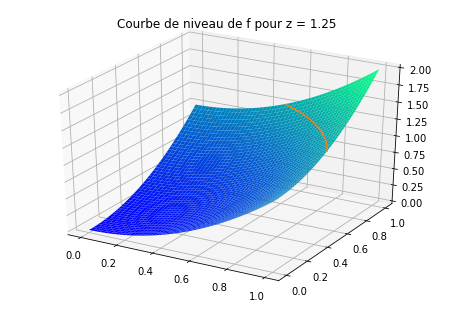

In [12]:
def Tracer3DfEtContourSimple(f, z0):
    """"Méthode permettant de tracer la ligne de niveau associé à une surface sur le domaine [0;1]x[0;1]"""
    #Premier essais
    courbeX,courbeY = simple_contour(f, c=z0, RechercheM0=RechercheM0ArreteDroite)

    #Création du graphe en 3D
    domain_x = np.linspace(0, 1)   
    domain_y = np.linspace(0, 1)
    X, Y = np.meshgrid(domain_x, domain_y)
    fig = plt.figure()
    ax = Axes3D(fig)

    #On trace f (même f qu'au départ)
    ax.plot_surface(X, Y, f(X, Y), cmap='winter')

    #On trace la courbe de niveau (en orange)
    ax.plot(courbeX, courbeY, z0)
    ax.set_title(f"Courbe de niveau de f pour z = {z0}")
    
    return ax
    
Tracer3DfEtContourSimple(f, 1.25)

### 5) Problème de précision : nécessité d'une autre méthode

Le soucis de cette méthode vient, de manière analogue à la méthode d'Euler pour la résolution d'équation différentielle, de la propagation d'une erreur qui peut vite devenir importante.

On se propose donc d'utiliser une autre méthode afin d'affiner la précision, en imposant qu'à chaque point que $f(M_n) = c$.

Pour cela, nous allons garder l'esprit général de la fonction. Sauf qu'au lieu de se contenter du point $M_{n+1}$ que nous avons trouvé, nous allons, depuis ce point, utiliser une méthode de Newton pour se rapprocher de la ligne de niveau et trouver un meilleur point tel que $f(M_{n+1})=c$.

Notons donc le point trouvé précédemment $M_{n+1}'$, point sur lequel nous allons nous reposer pour trouver une meilleure approximation $M_{n+1}$.

Pour cela, nous allons trouver la droite perpendiculaire à la tangente $D$ dans le plan $z=c$ passant par $M_{n+1}'$.
![Courbe de niveau dans le plan $z=c$](Explications/Figure_5.png)
*RQ : Les droites sont bien perpendiculaires, l'impression qu'elles ne le sont pas vient du fait que le repère n'est pas orthonormé*

Mathématiquement, vu que l'on cherche une droite passant par $M_{n+1}'$ perpendiculaire à la tangente trouvée précédemment qui était elle même perpendiculaire au gradiant par définition, alors on cherche une droite de vecteur directeur colinéaire avec le gradient en $M_n$, c'est à dire un vecteur $\vec{u}$ tel que $\vec{u} \wedge \vec{\nabla}f(M_n) = 0$. Comme il existe une infinité de solutions ($\vec{u}$ peut etre de taille quelconque), on peut arbitrairement imposer $\vec{u}^2 = \frac{\partial f}{\partial x}(M_n)^2 + \frac{\partial f}{\partial y}(M_n)^2$. Ainsi on se retrouve avec le système suivant :

$$(E) \iff \left\{
    \begin{array}{ll}
        \frac{\partial f}{\partial x}(M_n) \times u_y - \frac{\partial f}{\partial y}(M_n) \times u_x = 0 \\
        u_y^2 + u_x^2 = \frac{\partial f}{\partial y}(M_n)^2 + \frac{\partial f}{\partial x}(M_n)^2
    \end{array}
\right.$$

On reconnaît un système de la même forme que précédement, et donc avec $\lambda = \frac{\partial f}{\partial x}(M_n)$ et $\mu = \frac{\partial f}{\partial y}(M_n)$, on trouve toujours :

$$(E) \iff \left\{
\begin{array}{ll}
    u_x = \lambda \eta = \lambda = \frac{\partial f}{\partial x}(M_n)\\
    u_y = \mu \eta = \mu = \frac{\partial f}{\partial y}(M_n)
\end{array}\right. 
\text{ ou } \left\{
\begin{array}{ll}
    u_x = -\lambda \eta = -\lambda = \frac{\partial f}{\partial x}(M_n) \\
    u_y = -\mu \eta = -\mu = -\frac{\partial f}{\partial y}(M_n)
\end{array}\right. 
\text{ avec } \eta = \frac{\sqrt{\lambda^2 + \mu^2}}{\sqrt{\lambda^2 + \mu^2}} = 1$$

Système qui a également deux solutions, mais encore de façon arbitraire, on choisit la première sans réelle différence.
On a donc tout simplement $\vec{u}$ = $\vec{\nabla}f(M_n)$.

On peut alors utiliser la méthode de Newton sur f selon la direction de la droite $D'$ : on tombe alors sur un point appartenant, à un $\epsilon$ près arbitrairement petit, à la courbe de niveau.
![Courbe de niveau dans le plan $z=c$](Explications/Figure_6.png)

Mathématiquement, on applique la méthode de Newton à la fonction $h : t \longrightarrow f(t\vec{u} + \vec{M_{n+1}'}) - c = f(u_xt +x_{n+1}',u_yt + y_{n+1}') - c$ afin de trouver sa racine la plus proche, et l'on note alors ce point $M_{n+1}$.

De la même facon, on peut trouver tous les autres points. On perd alors la condition de distance $\delta$ entre chaques point, mais l'on gagne énormément en précision puisque chaque point est controlé sur la ligne de niveau.
![Courbe de niveau dans le plan $z=c$](Explications/Figure_7.png)

In [13]:
def TrouverMnp1(gradf, Mn, Mnp1prime, c = 0.0):
    """Méthode qui trouve le point Mn+1 à partir du point Mn+1' par la méthode expliquée ci-dessus"""
    u = gradf(Mn[0],Mn[1])
    h = lambda t : f(t*u[0] + Mnp1prime[0],t*u[1] + Mnp1prime[1])
    t0 = Newton(lambda t : h(t) - c)
    return (t0*u[0] + Mnp1prime[0], t0*u[1] + Mnp1prime[1])

def Newton(f, x = 0, eps = 10**(-10)):
    """Implémetation de la méthode de Newton"""
    i = 0
    N = 100
    while abs(f(x)) > eps:
        i+=1
        if i == N: #Compteur pour éviter les divergences
            raise ValueError("Divergence")
        if abs(derive(f)(x)) < eps:
            raise ValueError("Division par 0")
        x -= f(x)/derive(f)(x)
        
    return x
    

def simple_contour(f, c=0.0, delta=0.01, RechercheM0 = RechercheM0ArreteGauche):
    """Methode donnant la ligne de niveau de la fonction f a la hauteur c sur le domaine [0,1]^2
    Il est indispensable qu'il existe un point t tel que f(t,0) = c
    L'argument fonction de recherche donne une fonction visant à trouver la position du point M0 à utilisée"""
    gradf = grad(f)

    #Liste qui contiendra les points que nous trouvons appartenant à la courbe de niveau
    M = []
    
    #On commence par trouver M0, et l'on retourne une liste vide si jamais l'algorithme plante
    try :
        M.append(RechercheM0(f,c))
    except ValueError:
        return ([],[])

    #On en déduit alors le point M1', c'est à dire le seul point écarté de delta de M0 sur la droite D qui est dans le domaine
    M1primePotentiels = ProchainsPointsPotentiels(gradf, M[0], c, delta)
    if DansLeDomaine(M1primePotentiels[0]) :
        M1prime = M1primePotentiels[0]
    elif DansLeDomaine(M1primePotentiels[1]) :
        M1prime = M1primePotentiels[1]
    else:
        return ([],[])
    
    #On utilise à présent la méthode de Newton pour trouver les 0 de notre fonctions
    try :
        M.append(TrouverMnp1(gradf, M[0], M1prime, c))
    except ValueError as e:
        M.append(M1prime)
    

    #On lance alors l'algorithme de recherche récursif dans la limite d'un nombre N de points max
    N = 10000
    compteurErreur = 0
    for n in range(1,N):
        #On trouve les deux points potentiels au role de Mn+1 à partir de la position de Mn
        Mnp1primePotentiels = ProchainsPointsPotentiels(gradf, M[n], c, delta)

        #On choisit celui des deux qui est le plus éloigné de Mn-1 :
        Mnp1prime = ChoisirPointPlusEloigne(Mnp1primePotentiels, M[n-1])
        
        #On trouve Mn+1
        try:
            Mnp1 = TrouverMnp1(gradf, M[n], Mnp1prime, c)
        except ValueError as e:
            Mnp1 = Mnp1prime

        #On vérifie que le point est toujours dans le domaine, sinon on arrête
        if not DansLeDomaine(Mnp1):
            break;

        #On vérifie également que le point n'est pas confondu avec un des autres points deja calculés, sinon c'est que l'on boucle
        for Mi in M[:-1]:
            if (Mi[0] - Mnp1[0])**2 + (Mi[1] - Mnp1[1])**2 <= delta**2:
                break;

        #On peut continuer, et on ajoute notre point à la suite
        M.append(Mnp1)
    #La fin du programme devant retourner une liste de coordonée x et y, on décompose les coordonnées des points
    return ([Mi[0] for Mi in M], [Mi[1] for Mi in M])

Erreurs dans Newton : 0.0%


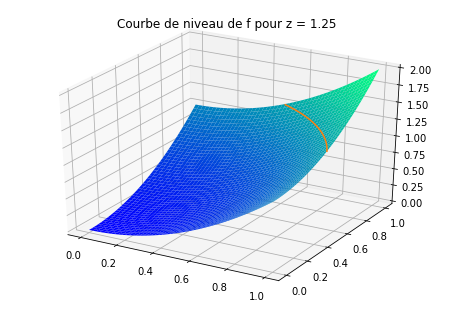

In [14]:
Tracer3DfEtContourSimple(f, 1.25)
# La ligne de niveau est là encore en orange.

## III) Généralisation avec `contour`

A présent, pour réaliser la fonction contour en se basant sur simple_contour, il va falloir :
- Utiliser les arguments $xc$ et $yc$ pour créer des intervalles, puis effectuer un produit cartésien de ces deux ensembles pour disposer d'un découpage du domaine complet en sous domaine.
- Puis pour chaque sous domaine $D = [x_0,x_1]\times[y_0,y_1]$, on va créer une fonction $g : [0,1]^2 \longrightarrow [x_0,x_1]\times[y_0,y_1]$ telle que $g(u,v) = f(x_0 + (x_1-x_0)u, y_0 + (y_1-y_0)v)$ afin de pouvoir travailler avec la fonction $g$ en utilisant la fonction `simple_contour`
- On peut à présent trouver les lignes de niveau de $g$ sur $[0,1]^2$ en utilisant 4 fois l'algorithme afin de partir des 4 arrêtes possibles. Puis, on modifie de la même façon les coordonénes des points trouvés afin qu'ils soient replacés dans l'espace de sortie correcte et non pas dans leur version normalisée. On obtient donc les points de la ligne de niveau de $f$ restreinte à $D$.
- En faisant cela pour chaque sous domaine, il ne reste qu'à faire l'union de tous les points trouvés pour avoir l'ensemble des points de la ligne de niveau de $f$ sur tout le domaine étudié.

In [15]:
def contour(f, c=0.0, xc=[0.0,1.0], yc=[0.0,1.0], delta=0.01):
    #Création de la division du domaine
    pairesX = [(xc[k],xc[k+1]) for k in range(len(xc)-1)]
    pairesY = [(yc[k],yc[k+1]) for k in range(len(yc)-1)]
    carres = []
    for X in pairesX:
        for Y in pairesY:
            carres.append((X,Y))
            
    #Listes qui vont contenir tous les points
    LX, LY = [], []
    for carre in carres:
        #On normalise la fonction f pour s'adapter au carre dans lequel on travaille
        x0,x1,y0,y1 = carre[0][0], carre[0][1], carre[1][0], carre[1][1]
        LXn, LYn = [], []
        g = lambda u,v : f(x0 + (x1-x0)*u, y0 + (y1-y0)*v)
        
        #On lance les recherche
        for F in [RechercheM0ArreteGauche, RechercheM0ArreteDroite, RechercheM0ArreteHaute, RechercheM0ArreteBasse]:
            Ltemp = simple_contour(g, c, delta, RechercheM0=F)
            LXn += Ltemp[0]
            LYn += Ltemp[1]

        #On "dénormalise" les points
        LX += [x0 + (x1-x0)*x for x in LXn]
        LY += [y0 + (y1-y0)*y for y in LYn]
        
    return LX, LY


Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%


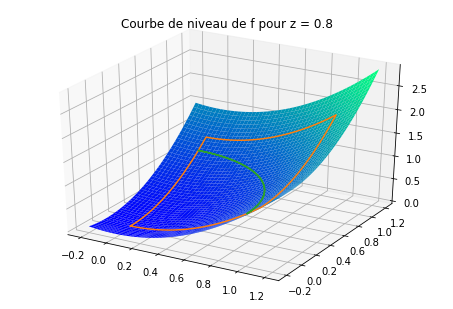

In [16]:
# Premier essais avec un plan z = 
z0 = 0.8
courbeX,courbeY = contour(f, c=z0)

# Création du graphe de f en 3D
domain_x = np.linspace(0 - 0.2, 1 + 0.2)   
domain_y = np.linspace(0 - 0.2, 1 + 0.2)
X, Y = np.meshgrid(domain_x, domain_y)
fig = plt.figure()
ax = Axes3D(fig)

# On trace f
ax.plot_surface(X, Y, f(X, Y), cmap='winter')

# On trace les contours
Contours = [(0,y) for y in np.linspace(0,1,1000)]
Contours += [(x,1) for x in np.linspace(0,1,1000)]
Contours += [(1,1-y) for y in np.linspace(0,1,1000)]
Contours += [(1-x,0) for x in np.linspace(0,1,1000)]
ax.plot([e[0] for e in Contours], [e[1] for e in Contours], [f(e[0],e[1]) for e in Contours])

# On trace la courbe de niveau
ax.plot(courbeX, courbeY, z0)
ax.set_title(f"Courbe de niveau de f pour z = {z0}")

### Application sur l'exemple du cours

Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.01%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.01%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.01%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.01%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.01%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.01%
Divergence
Erreurs dans Newton : 0.01%
Erreurs dans Newton : 0.01%
Divergence
Erreurs dans Newton : 0.02%
Erreurs dans Newton : 0.0%
Divergence
Erreurs dans Newton : 0.04%
Erreurs dans Newton : 0.0%
Divergence
Erreurs dans Newton : 0.06%
Erreurs dans Newton : 0.0%
Divergence
Erreurs dans Newton : 0.1%
Erreurs dans Newton : 0.0%
Divergence
Erreurs dans Newton : 0.01%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erre

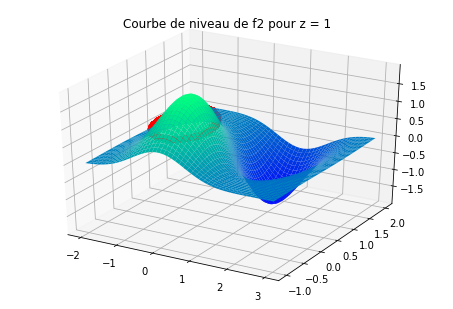

In [17]:
def f2(x,y):
    return 2*(np.exp(-np.power(x,2)-np.power(y,2)) - np.exp(-np.power(x-1,2)-np.power(y-1,2)))

# Création du graphe en 3D
domain_x = np.linspace(-2,3)   
domain_y = np.linspace(-1,2)
X, Y = np.meshgrid(domain_x, domain_y)
fig = plt.figure()
ax = Axes3D(fig)

# On trace f
ax.plot_surface(X, Y, f2(X, Y), cmap='winter')

# On trace la ligne de niveau
z0 = 1
courbeX,courbeY = contour(f2, c=z0, xc = np.linspace(-2,3,100), yc = np.linspace(-1,2,100))
ax.scatter(courbeX, courbeY, z0, c="red")
ax.set_title(f"Courbe de niveau de f2 pour z = {z0}")

Divergence
Erreurs dans Newton : 0.27%
Divergence
Erreurs dans Newton : 0.27%
Divergence
Erreurs dans Newton : 1.0%
Divergence
Erreurs dans Newton : 1.0%
Divergence
Erreurs dans Newton : 1.0%
Divergence
Erreurs dans Newton : 1.0%
Divergence
Erreurs dans Newton : 0.83%
Divergence
Erreurs dans Newton : 0.84%
Divergence
Erreurs dans Newton : 0.07%
Divergence
Erreurs dans Newton : 0.07%
Divergence
Erreurs dans Newton : 1.04%
Divergence
Erreurs dans Newton : 1.04%
Divergence
Erreurs dans Newton : 1.03%
Divergence
Erreurs dans Newton : 1.03%
Divergence
Erreurs dans Newton : 1.01%
Divergence
Erreurs dans Newton : 1.01%
Divergence
Erreurs dans Newton : 1.01%
Divergence
Erreurs dans Newton : 1.01%
Divergence
Erreurs dans Newton : 0.73%
Divergence
Erreurs dans Newton : 0.72%
Divergence
Erreurs dans Newton : 0.16%
Divergence
Erreurs dans Newton : 0.16%
Divergence
Erreurs dans Newton : 1.0%
Divergence
Erreurs dans Newton : 1.0%
Divergence
Erreurs dans Newton : 1.02%
Divergence
Erreurs dans Newton 

Erreurs dans Newton : 1.03%
Divergence
Erreurs dans Newton : 0.23%
Divergence
Erreurs dans Newton : 0.23%
Divergence
Erreurs dans Newton : 0.89%
Divergence
Erreurs dans Newton : 0.89%
Divergence
Erreurs dans Newton : 1.07%
Divergence
Erreurs dans Newton : 1.07%
Divergence
Erreurs dans Newton : 0.74%
Divergence
Erreurs dans Newton : 0.74%
Divergence
Erreurs dans Newton : 0.68%
Divergence
Erreurs dans Newton : 0.68%
Divergence
Erreurs dans Newton : 1.07%
Divergence
Erreurs dans Newton : 1.07%
Divergence
Erreurs dans Newton : 1.0%
Divergence
Erreurs dans Newton : 1.0%
Divergence
Erreurs dans Newton : 0.35%
Divergence
Erreurs dans Newton : 0.35%
Divergence
Erreurs dans Newton : 1.14%
Divergence
Erreurs dans Newton : 1.14%
Divergence
Erreurs dans Newton : 0.54%
Divergence
Erreurs dans Newton : 0.54%
Divergence
Erreurs dans Newton : 0.91%
Divergence
Erreurs dans Newton : 0.91%
Divergence
Erreurs dans Newton : 1.09%
Divergence
Erreurs dans Newton : 1.09%
Divergence
Erreurs dans Newton : 0.39%

Erreurs dans Newton : 0.28%
Divergence
Erreurs dans Newton : 0.28%
Divergence
Erreurs dans Newton : 1.01%
Divergence
Erreurs dans Newton : 1.01%
Divergence
Erreurs dans Newton : 1.02%
Divergence
Erreurs dans Newton : 1.02%
Divergence
Erreurs dans Newton : 1.02%
Divergence
Erreurs dans Newton : 1.02%
Divergence
Erreurs dans Newton : 1.03%
Divergence
Erreurs dans Newton : 1.03%
Divergence
Erreurs dans Newton : 0.1%
Divergence
Erreurs dans Newton : 0.1%
Divergence
Erreurs dans Newton : 0.87%
Divergence
Erreurs dans Newton : 0.88%
Divergence
Erreurs dans Newton : 1.0%
Divergence
Erreurs dans Newton : 1.0%
Divergence
Erreurs dans Newton : 1.0%
Divergence
Erreurs dans Newton : 1.0%
Divergence
Erreurs dans Newton : 1.0%
Divergence
Erreurs dans Newton : 1.0%
Divergence
Erreurs dans Newton : 1.0%
Divergence
Erreurs dans Newton : 1.0%
Divergence
Erreurs dans Newton : 1.0%
Divergence
Erreurs dans Newton : 1.0%
Divergence
Erreurs dans Newton : 1.0%
Divergence
Erreurs dans Newton : 1.0%
Divergence


Erreurs dans Newton : 0.66%
Divergence
Erreurs dans Newton : 0.66%
Divergence
Erreurs dans Newton : 0.37%
Divergence
Erreurs dans Newton : 0.37%
Divergence
Erreurs dans Newton : 0.89%
Divergence
Erreurs dans Newton : 0.89%
Divergence
Erreurs dans Newton : 1.2%
Divergence
Erreurs dans Newton : 1.2%
Divergence
Erreurs dans Newton : 0.92%
Divergence
Erreurs dans Newton : 0.92%
Divergence
Erreurs dans Newton : 0.21%
Divergence
Erreurs dans Newton : 0.21%
Divergence
Erreurs dans Newton : 1.08%
Divergence
Erreurs dans Newton : 1.08%
Divergence
Erreurs dans Newton : 0.61%
Divergence
Erreurs dans Newton : 0.61%
Divergence
Erreurs dans Newton : 0.43%
Divergence
Erreurs dans Newton : 0.43%
Divergence
Erreurs dans Newton : 1.01%
Divergence
Erreurs dans Newton : 1.01%
Divergence
Erreurs dans Newton : 1.0%
Divergence
Erreurs dans Newton : 1.0%
Divergence
Erreurs dans Newton : 1.01%
Divergence
Erreurs dans Newton : 1.01%
Divergence
Erreurs dans Newton : 0.71%
Divergence
Erreurs dans Newton : 0.71%
D

Erreurs dans Newton : 1.16%
Divergence
Erreurs dans Newton : 1.16%
Divergence
Erreurs dans Newton : 0.77%
Divergence
Erreurs dans Newton : 0.77%
Divergence
Erreurs dans Newton : 0.77%
Divergence
Erreurs dans Newton : 0.77%
Divergence
Erreurs dans Newton : 1.16%
Divergence
Erreurs dans Newton : 1.16%
Divergence
Erreurs dans Newton : 0.38%
Divergence
Erreurs dans Newton : 0.38%
Divergence
Erreurs dans Newton : 1.16%
Divergence
Erreurs dans Newton : 1.16%
Divergence
Erreurs dans Newton : 0.38%
Divergence
Erreurs dans Newton : 0.38%
Divergence
Erreurs dans Newton : 1.16%
Divergence
Erreurs dans Newton : 1.16%
Divergence
Erreurs dans Newton : 0.77%
Divergence
Erreurs dans Newton : 0.77%
Divergence
Erreurs dans Newton : 0.77%
Divergence
Erreurs dans Newton : 0.77%
Divergence
Erreurs dans Newton : 1.16%
Divergence
Erreurs dans Newton : 1.16%
Divergence
Erreurs dans Newton : 0.38%
Divergence
Erreurs dans Newton : 0.38%
Divergence
Erreurs dans Newton : 1.16%
Divergence
Erreurs dans Newton : 1.1

Erreurs dans Newton : 1.16%
Divergence
Erreurs dans Newton : 0.77%
Divergence
Erreurs dans Newton : 0.77%
Divergence
Erreurs dans Newton : 0.77%
Divergence
Erreurs dans Newton : 0.77%
Divergence
Erreurs dans Newton : 1.16%
Divergence
Erreurs dans Newton : 1.16%
Divergence
Erreurs dans Newton : 0.38%
Divergence
Erreurs dans Newton : 0.38%
Divergence
Erreurs dans Newton : 1.16%
Divergence
Erreurs dans Newton : 1.16%
Divergence
Erreurs dans Newton : 0.38%
Divergence
Erreurs dans Newton : 0.38%
Divergence
Erreurs dans Newton : 1.16%
Divergence
Erreurs dans Newton : 1.16%
Divergence
Erreurs dans Newton : 1.16%
Divergence
Erreurs dans Newton : 0.77%
Divergence
Erreurs dans Newton : 0.77%
Divergence
Erreurs dans Newton : 0.77%
Divergence
Erreurs dans Newton : 0.77%
Divergence
Erreurs dans Newton : 1.16%
Divergence
Erreurs dans Newton : 1.16%
Divergence
Erreurs dans Newton : 1.16%
Divergence
Erreurs dans Newton : 0.38%
Divergence
Erreurs dans Newton : 0.38%
Divergence
Erreurs dans Newton : 1.1

Erreurs dans Newton : 0.26%
Erreurs dans Newton : 0.0%
Divergence
Erreurs dans Newton : 0.23%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Ne

Erreurs dans Newton : 0.33%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Divergence
Erreurs dans Newton : 0.36%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Divergence
Erreurs dans Newton : 0.31%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Divergence
Erreurs dans Newton : 0.09%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Divergence
Erreurs dans Newton : 0.2%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs

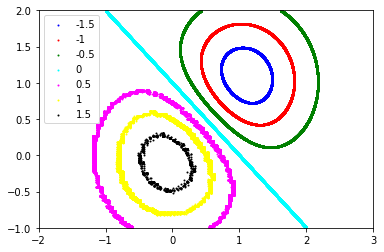

In [18]:
# On trace différentes lignes de niveau avec différents c en 2D
for c,color in [(-1.5,"blue"), (-1, "red"), (-0.5, "green"), (0,"cyan"), (0.5,"magenta"), (1,"yellow"), (1.5,"black")]:
    courbeX,courbeY = contour(f2, c=c, xc = np.linspace(-2,3,100), yc = np.linspace(-1,2,100))
    plt.scatter(courbeX, courbeY, label=str(c), c=color, s=1)
plt.xlim(-2,3)
plt.ylim(-1,2)
plt.legend()
plt.show()

Divergence
Erreurs dans Newton : 0.79%
Divergence
Erreurs dans Newton : 0.79%
Divergence
Erreurs dans Newton : 1.06%
Divergence
Erreurs dans Newton : 1.06%
Divergence
Erreurs dans Newton : 1.01%
Divergence
Erreurs dans Newton : 1.01%
Divergence
Erreurs dans Newton : 1.0%
Divergence
Erreurs dans Newton : 1.0%
Divergence
Erreurs dans Newton : 1.06%
Divergence
Erreurs dans Newton : 1.06%
Divergence
Erreurs dans Newton : 0.84%
Divergence
Erreurs dans Newton : 0.84%
Divergence
Erreurs dans Newton : 1.11%
Divergence
Erreurs dans Newton : 1.11%
Divergence
Erreurs dans Newton : 0.37%
Divergence
Erreurs dans Newton : 0.37%
Divergence
Erreurs dans Newton : 0.62%
Divergence
Erreurs dans Newton : 0.62%
Divergence
Erreurs dans Newton : 0.5%
Divergence
Erreurs dans Newton : 0.5%
Divergence
Erreurs dans Newton : 0.74%
Divergence
Erreurs dans Newton : 0.74%
Divergence
Erreurs dans Newton : 0.37%
Divergence
Erreurs dans Newton : 0.37%
Divergence
Erreurs dans Newton : 1.01%
Divergence
Erreurs dans Newto

Erreurs dans Newton : 0.83%
Divergence
Erreurs dans Newton : 0.44%
Divergence
Erreurs dans Newton : 0.44%
Divergence
Erreurs dans Newton : 1.0%
Divergence
Erreurs dans Newton : 1.0%
Divergence
Erreurs dans Newton : 0.13%
Divergence
Erreurs dans Newton : 0.13%
Divergence
Erreurs dans Newton : 1.0%
Divergence
Erreurs dans Newton : 1.0%
Divergence
Erreurs dans Newton : 1.03%
Divergence
Erreurs dans Newton : 1.03%
Divergence
Erreurs dans Newton : 1.03%
Divergence
Erreurs dans Newton : 1.03%
Divergence
Erreurs dans Newton : 1.09%
Divergence
Erreurs dans Newton : 1.09%
Divergence
Erreurs dans Newton : 1.0%
Divergence
Erreurs dans Newton : 1.0%
Divergence
Erreurs dans Newton : 0.95%
Divergence
Erreurs dans Newton : 0.95%
Divergence
Erreurs dans Newton : 0.24%
Divergence
Erreurs dans Newton : 0.23%
Divergence
Erreurs dans Newton : 0.59%
Divergence
Erreurs dans Newton : 0.58%
Divergence
Erreurs dans Newton : 0.52%
Divergence
Erreurs dans Newton : 0.52%
Divergence
Erreurs dans Newton : 0.64%
Div

Erreurs dans Newton : 0.73%
Divergence
Erreurs dans Newton : 0.73%
Divergence
Erreurs dans Newton : 0.98%
Divergence
Erreurs dans Newton : 0.98%
Divergence
Erreurs dans Newton : 1.22%
Divergence
Erreurs dans Newton : 1.22%
Divergence
Erreurs dans Newton : 1.22%
Divergence
Erreurs dans Newton : 0.49%
Divergence
Erreurs dans Newton : 0.49%
Divergence
Erreurs dans Newton : 0.49%
Divergence
Erreurs dans Newton : 0.49%
Divergence
Erreurs dans Newton : 1.22%
Divergence
Erreurs dans Newton : 1.22%
Divergence
Erreurs dans Newton : 1.22%
Division par 0
Erreurs dans Newton : 0.98%
Divergence
Erreurs dans Newton : 0.98%
Divergence
Erreurs dans Newton : 0.73%
Divergence
Erreurs dans Newton : 0.73%
Divergence
Erreurs dans Newton : 0.24%
Divergence
Erreurs dans Newton : 0.24%
Division par 0
Erreurs dans Newton : 1.22%
Division par 0
Erreurs dans Newton : 1.22%
Divergence
Erreurs dans Newton : 0.24%
Divergence
Erreurs dans Newton : 0.24%
Division par 0
Erreurs dans Newton : 0.73%
Division par 0
Erreu

Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Divergence
Erreurs dans Newton : 0.06%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans Newton : 0.0%
Erreurs dans New

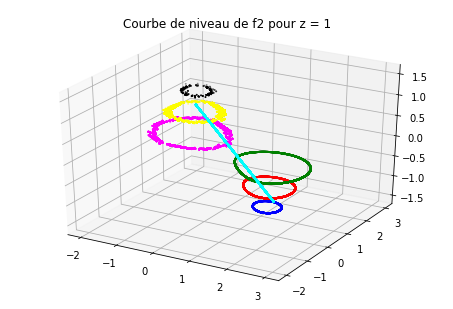

In [19]:
# Création du graphe en 3D
domain_x = np.linspace(-3,4)   
domain_y = np.linspace(-2,3)
X, Y = np.meshgrid(domain_x, domain_y)
fig = plt.figure()
ax = Axes3D(fig)

# On trace la ligne de niveau
for c,color in [(-1.5,"blue"), (-1, "red"), (-0.5, "green"), (0,"cyan"), (0.5,"magenta"), (1,"yellow"), (1.5,"black")]:
    courbeX,courbeY = contour(f2, c=c, xc = domain_x, yc = domain_y)
    ax.scatter(courbeX, courbeY, c, label=str(c), c=color, s=1)
    
ax.set_title(f"Courbe de niveau de f2 pour z = {z0}")

### Conclusion

On a réussi à obtenir par deux méthodes différentes la/les ligne(s) de niveau d'une fonction f (testée ici avec une fonction quadratique).
Chacune de ces méthodes présentes des avantages et des inconvénients :
- la première présente l'avantage d'être rapide mais perd en précision
- la deuxième est beaucoup plus précise mais nécéssite un temps d'exécution beaucoup plus long.
On fait ici face au problèmes classque du compromis entre temps et précison.
A vérifier avec le code :

`import time
starttime = time.time()
... code de chaucne des méthodes...
print("Temps d execution : %s secondes ---" % (time.time() - start_time))`